In [39]:
import sys
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np


sys.path.append("..")

from magnetic_isolation.solutions import theta_values


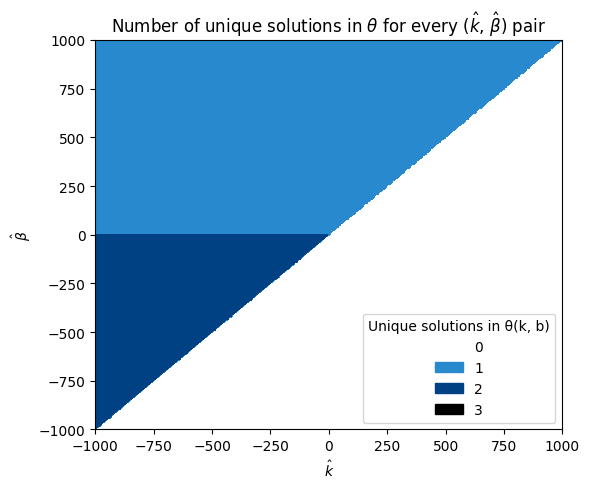

In [40]:
count_unique = lambda k, b: len(np.unique(theta_values(k, b)))  # Assuming theta_values is defined

min_k = -1000
max_k = 1000
min_b = -1000
max_b = 1000
n_points = 400

k = np.linspace(min_k, max_k, n_points)
b = np.linspace(min_b, max_b, n_points)
K, B = np.meshgrid(k, b)
Z = np.vectorize(count_unique)(K, B)

# Set levels from 0 to 3 (exclusive of 4), one per unique count
levels = np.arange(0, 4)
colors = ["#FFFFFF", "#2989ce", "#004183", "#000000"] 

plt.figure(figsize=(6, 5))
contour = plt.contourf(K, B, Z, levels=levels, colors=colors, extend='both')

# Add a colorbar with labels
legend_labels = [str(i) for i in range(4)]
legend_patches = [Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]

plt.legend(handles=legend_patches, title='Unique solutions in θ(k, b)', loc='lower right')

plt.xlabel('$\\hat{k}$')
plt.ylabel('$\\hat{\\beta}$')
plt.title('Number of unique solutions in $\\theta$ for every ($\\hat{k}$, $\\hat{\\beta}$) pair')
plt.tight_layout()
plt.show()

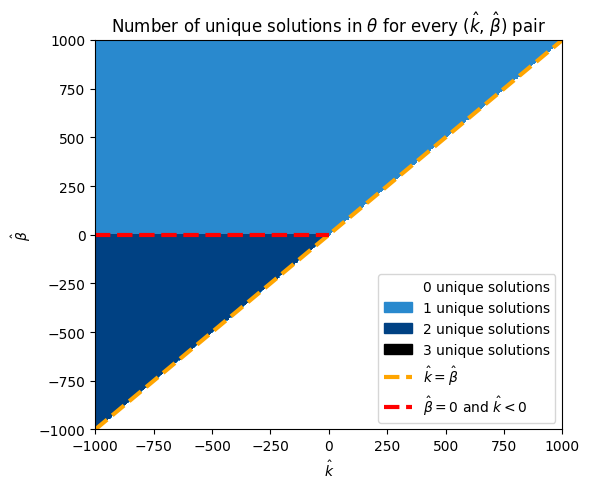

In [43]:
count_unique = lambda k, b: len(np.unique(theta_values(k, b)))  # Assuming theta_values is defined

min_k = -1000
max_k = 1000
min_b = -1000
max_b = 1000
n_points = 400

k = np.linspace(min_k, max_k, n_points)
b = np.linspace(min_b, max_b, n_points)
K, B = np.meshgrid(k, b)
Z = np.vectorize(count_unique)(K, B)

# Set levels from 0 to 3 (exclusive of 4), one per unique count
levels = np.arange(0, 4)
colors = ["#FFFFFF", "#2989ce", "#004183", "#000000"] 

plt.figure(figsize=(6, 5))
contour = plt.contourf(K, B, Z, levels=levels, colors=colors, extend='both')
line1, = plt.plot([min_k,max_k], [min_b, max_b], color='orange', linestyle='--', linewidth=3, label = '$\\hat{k} = \\hat{\\beta}$')
line2, = plt.plot([min_k,0], [0, 0], color='red', linestyle='--', linewidth=3, label = '$\\hat{\\beta} = 0$ and $\\hat{k} < 0$')

# Add a colorbar with labels
legend_labels = [str(i) + ' unique solutions' for i in range(4)]
legend_patches = [Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]

all_handles = legend_patches + [line1, line2]

plt.legend(handles=all_handles,  loc='lower right')

plt.xlabel('$\\hat{k}$')
plt.ylabel('$\\hat{\\beta}$')
plt.title('Number of unique solutions in $\\theta$ for every ($\\hat{k}$, $\\hat{\\beta}$) pair')
plt.tight_layout()
plt.show()